In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import quandl
import statistics

from sklearn.preprocessing import MinMaxScaler

from keras.models import Sequential
from keras.layers import LSTM, Dense

# free data capture limits for some sources
# Get stock data from tiingo
# Ge treaury data from Quandl
import requests

#You need this for prediction date extraction
import time
from datetime import datetime, date, time, timedelta

nan=np.nan

In [2]:
DBGmode = 0
WritetoFile = 0

pd.set_option('display.max_rows', 15)
ticker = 'NVDA'
st_date = '2018-1-1'
en_date = '2020-9-18'

timestep = 5
TrainPCT = 0.85

ADDUS10Y = 1

ADDXMA = 0
xmasmall = 7
xmalong = 21

ADDRSI = 1
RSIwindow = 21

epochval = 100 #iter when entire dataset is passed fwd/back thru NN
batchval = 32  #training examples in a singler batch

In [3]:
us10y_data = quandl.get("FRED/DGS10", start_date=st_date, end_date=en_date, api_key = 'tNjFxT5wYAG7nbemafxi')
us10y_data=us10y_data.reset_index()
us10y_data.rename(columns = {'Value':'US10Y'}, inplace = True) 

if DBGmode==1:
    us10y_data

In [4]:
for row in range(0,len(us10y_data)):
    us10y_data['Date'][row]=str(us10y_data['Date'][row])[:10]+'T00:00:00.000Z'
us10y_data=us10y_data.set_index('Date')

if DBGmode==1:
    us10y_data

<ipython-input-4-83275a74f87b>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  us10y_data['Date'][row]=str(us10y_data['Date'][row])[:10]+'T00:00:00.000Z'
/Users/prasannaob/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [5]:
def get_stock_data(stock_symbol, start_date, end_date):
    base_url = f'https://api.tiingo.com/tiingo/daily/{stock_symbol}/prices?'
    token = '59e2dfca5859e44a55ef766a8f81aab1ab8a80e8'
    payload = {
        'startDate': start_date,
        'endDate': end_date,
        'token': token
    }
    response = requests.get(base_url, params=payload)
    return response

In [6]:
response = get_stock_data(ticker, st_date, en_date)

if DBGmode == 1:
    print(response.url)
    print(response.json())

In [7]:
def parse_data(data_response):
    json_data = data_response.json()
    dates = []
    closes =[]
    opens = []
    highs = []
    lows = []
    vols = []
    for json_object in json_data:
        dates.append(json_object['date'])
        closes.append(json_object['close'])
        opens.append(json_object['open'])
        highs.append(json_object['high'])
        lows.append(json_object['low'])
        vols.append(json_object['volume'])
    return dates, closes, opens, highs, lows, vols

In [8]:
dates, closes, opens, highs, lows, vols = parse_data(response)

if DBGmode == 1:
    print(dates, closes)

In [9]:
#**** Define New Column Label here
datastock = pd.DataFrame(columns = ['Close'], index = dates)
dfindex = datastock.index
dfindex.name = 'Date'

In [10]:
#**** ADD New Column Data here
datastock['Close']=closes
#datastock['Volume']=vols

if DBGmode == 1:
    datastock

In [11]:
if DBGmode == 1:
    plt.plot(datastock['Close'], label=ticker+' Closes')
    plt.legend()
    plt.show()

In [12]:
print('Total Stock Rows = ', len(datastock))
print('Total US10Y Rows = ', len(us10y_data))

if ADDUS10Y==1:
    #****APPEND US10Y data here to a separate column in a new dataframe
    data=pd.concat([datastock, us10y_data], axis=1, sort=False)

    #fill US10Y NaN with previous value
    data['US10Y'].fillna(method='ffill', inplace=True)

else:
    data=datastock
    
data

Total Stock Rows =  684
Total US10Y Rows =  679


,Close,US10Y
2018-01-02T00:00:00.000Z,199.35,2.46
2018-01-03T00:00:00.000Z,212.47,2.44
2018-01-04T00:00:00.000Z,213.59,2.46
2018-01-05T00:00:00.000Z,215.40,2.47
2018-01-08T00:00:00.000Z,222.00,2.49
...,...,...
2020-09-14T00:00:00.000Z,514.89,0.68
2020-09-15T00:00:00.000Z,519.64,0.68
2020-09-16T00:00:00.000Z,500.58,0.69
2020-09-17T00:00:00.000Z,498.54,0.69


In [13]:
#Add XMA here

if ADDXMA == 1:
    #Enter SMA Data - defined at the top
    #data['Close-XMA5'] = data.iloc[:,0].rolling(window=xmasmall).mean()
    #data['Close-XMA9'] = data.iloc[:,0].rolling(window=xmalong).mean()

    #Enter EMA Data - defined at the top
    data['Close-XMA'+str(xmasmall)] = data.iloc[:,0].ewm(span=xmasmall, adjust=False).mean()
    data['Close-XMA'+str(xmalong)] = data.iloc[:,0].ewm(span=xmalong, adjust=False).mean()

    droprow=xmalong
    data.drop(data.index[0:droprow], inplace = True)

In [14]:
def computeRSI (data, time_window):
    diff = data.diff(1).dropna()        # diff in one field(one day)

    #this preservers dimensions off diff values
    up_chg = 0 * diff
    down_chg = 0 * diff
    
    # up change is equal to the positive difference, otherwise equal to zero
    up_chg[diff > 0] = diff[ diff>0 ]
    
    # down change is equal to negative deifference, otherwise equal to zero
    down_chg[diff < 0] = diff[ diff < 0 ]
    
    # check pandas documentation for ewm
    # https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.ewm.html
    # values are related to exponential decay
    # we set com=time_window-1 so we get decay alpha=1/time_window
    up_chg_avg   = up_chg.ewm(com=time_window-1 , min_periods=time_window).mean()
    down_chg_avg = down_chg.ewm(com=time_window-1 , min_periods=time_window).mean()
    
    rs = abs(up_chg_avg/down_chg_avg)
    rsi = 100 - 100/(1+rs)
    return rsi

In [15]:
#Add RSI here
if ADDRSI == 1:
    data['Close-RSI'+str(RSIwindow)] = computeRSI(data['Close'], RSIwindow)
    data.drop(data.index[0:RSIwindow], inplace = True)

In [16]:
data_noofcols = len(data.columns)
print('Number of data columns = ', data_noofcols)

Number of data columns =  3


In [17]:
data

,Close,US10Y,Close-RSI21
2018-02-01T00:00:00.000Z,240.50,2.78,71.617446
2018-02-02T00:00:00.000Z,233.52,2.84,62.205161
2018-02-05T00:00:00.000Z,213.70,2.77,44.692608
2018-02-06T00:00:00.000Z,225.58,2.79,53.017217
2018-02-07T00:00:00.000Z,228.80,2.84,54.947105
...,...,...,...
2020-09-14T00:00:00.000Z,514.89,0.68,57.550703
2020-09-15T00:00:00.000Z,519.64,0.68,58.274657
2020-09-16T00:00:00.000Z,500.58,0.69,54.368021
2020-09-17T00:00:00.000Z,498.54,0.69,53.961481


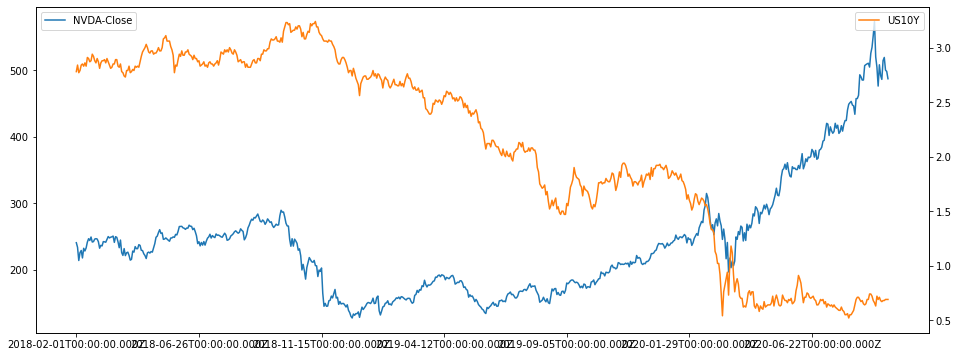

In [18]:
plt.figure()
data['Close'].plot(figsize=(16,6), label=ticker+'-Close')
if ADDXMA==1:
    data['Close-XMA'+str(xmasmall)].plot(label=ticker+'-EMA'+str(xmasmall))
    data['Close-XMA'+str(xmalong)].plot(label=ticker+'-EMA'+str(xmalong))
plt.legend()
if ADDUS10Y==1:
    data['US10Y'].plot(secondary_y=True, label='US10Y')
plt.legend()
plt.show()

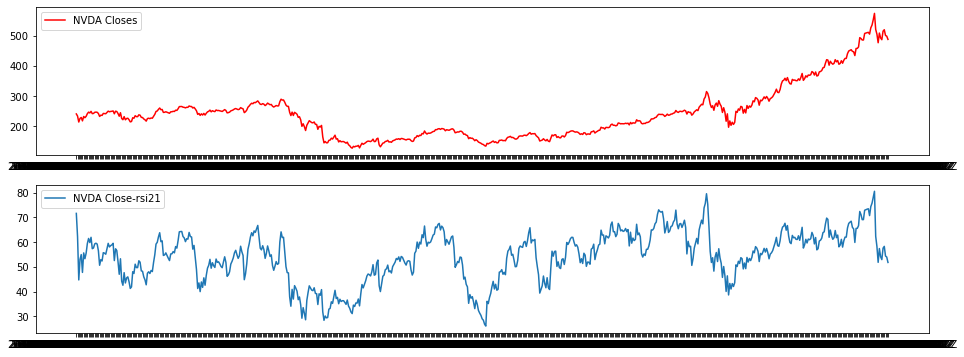

In [19]:
fig, axs = plt.subplots(2,1,figsize=(16,6))
axs[0].plot(data['Close'], color='r', label=ticker+' Closes')
if ADDXMA==1:
    axs[0].plot(data['Close-XMA'+str(xmasmall)], label=ticker+' Close-ema'+str(xmasmall))
    axs[0].plot(data['Close-XMA'+str(xmalong)], label=ticker+' Close-ema'+str(xmalong))
axs[0].legend()
if ADDRSI==1:
    axs[1].plot(data['Close-RSI'+str(RSIwindow)], label=ticker+' Close-rsi'+str(RSIwindow))
    axs[1].legend()
plt.show()

In [20]:
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)

print('Length of scaled_data = ', len(scaled_data))
print(scaled_data)

Length of scaled_data =  663
[[0.25386096 0.83088235 0.83590487]
 [0.23823806 0.85294118 0.66333608]
 [0.19387618 0.82720588 0.34225358]
 ...
 [0.83598192 0.0625     0.51964667]
 [0.83141591 0.0625     0.51219298]
 [0.80686244 0.0625     0.47211395]]


In [21]:
train_length = int(len(scaled_data) * TrainPCT)
test_length = len(scaled_data) - train_length
train_data = scaled_data[0:train_length,:]
test_data = scaled_data[train_length:len(scaled_data),:]

if DBGmode == 1:
    print('scaled_data length =', len(scaled_data))
    print('train_length = ', train_length)
    print('test_length = ', test_length)
    print(train_data)
    print(test_data)

In [22]:
def create_dataset(dataset, noofcols, timestep=1):
    data_x, data_y = [], []
    for i in range(len(dataset) - timestep):
        data_x.append(dataset[i:(i+timestep),0:noofcols])
        data_y.append(dataset[i+timestep,0])
    #It has been shown that Numpy arrays need 4 times less memory compared to Python lists
    return np.array(data_x), np.array(data_y)

In [23]:
train_x, train_y = create_dataset(train_data, data_noofcols, timestep)
test_x, test_y = create_dataset(test_data, data_noofcols, timestep)

if DBGmode == 1:
    print(train_x)

In [24]:
if DBGmode == 1:
    print(train_y)

In [25]:
print('#Samples, #Timesteps, #Features - for input to LSTM')
print('train_x shape = ', train_x.shape)
print('test_x shape = ', test_x.shape)
print('train_y shape = ', train_y.shape)
print('test_y shape = ', test_y.shape)

#Samples, #Timesteps, #Features - for input to LSTM
train_x shape =  (558, 5, 3)
test_x shape =  (95, 5, 3)
train_y shape =  (558,)
test_y shape =  (95,)


In [26]:
##Samples, #Timesteps, #Features - for input to LSTM'
#train_x = np.reshape(train_x, (train_x.shape[0], train_x.shape[1], data_noofcols))
#test_x = np.reshape(test_x, (test_x.shape[0], test_x.shape[1], data_noofcols))

if DBGmode == 1:
    print(train_x)

In [27]:
#optimizer = 'adam' 'SGD' 'RMSprop' 'adadelta' 'adagrad' 'adamax' 'nadam' 'ftrl'
#activation = 'sigmoid' 'linear' relu' 'softmax' 'softplus' 'softsign' 'tanh' selu' 'elu' 'exponential' 
#loss = 'binary_crossentropy' 'mean_squared_error'

#LSTM input_shape = #timestep, #features
model = Sequential()
#model.add(LSTM(256, input_shape=(1,data_noofcols)))
model.add(LSTM(50, return_sequences=True, input_shape=(timestep,data_noofcols)))
model.add(LSTM(50, return_sequences=False))
#model.add(Dense(1, activation='sigmoid'))
#model.add(Dense(6, input_dim=6, activation='relu'))
model.add(Dense(25))
model.add(Dense(1))
#model.add(Dense(1, activation=None))
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 5, 50)             10800     
_________________________________________________________________
lstm_1 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense (Dense)                (None, 25)                1275      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 26        
Total params: 32,301
Trainable params: 32,301
Non-trainable params: 0
_________________________________________________________________
None


In [28]:
model.fit(train_x, train_y, epochs=epochval, batch_size=batchval, verbose=1)
score = model.evaluate(train_x, train_y, verbose=0)
print('Keras model loss = ', score[0])
print('Keras model accuracy = ', score[1])

Epoch 1/100
18/18 [==============================] - 0s 6ms/step - loss: 0.0129 - accuracy: 0.0018
Epoch 2/100
18/18 [==============================] - 0s 5ms/step - loss: 0.0065 - accuracy: 0.0018
Epoch 3/100
18/18 [==============================] - 0s 5ms/step - loss: 0.0034 - accuracy: 0.0018
Epoch 4/100
18/18 [==============================] - 0s 5ms/step - loss: 0.0014 - accuracy: 0.0018
Epoch 5/100
18/18 [==============================] - 0s 4ms/step - loss: 7.3959e-04 - accuracy: 0.0018
Epoch 6/100
18/18 [==============================] - 0s 4ms/step - loss: 5.8080e-04 - accuracy: 0.0018
Epoch 7/100
18/18 [==============================] - 0s 5ms/step - loss: 5.2708e-04 - accuracy: 0.0018
Epoch 8/100
18/18 [==============================] - 0s 4ms/step - loss: 5.1240e-04 - accuracy: 0.0018
Epoch 9/100
18/18 [==============================] - 0s 4ms/step - loss: 5.1241e-04 - accuracy: 0.0018
Epoch 10/100
18/18 [==============================] - 0s 5ms/step - loss: 4.9754e-04 - ac

18/18 [==============================] - 0s 4ms/step - loss: 3.0270e-04 - accuracy: 0.0018
Epoch 81/100
18/18 [==============================] - 0s 4ms/step - loss: 3.1527e-04 - accuracy: 0.0018
Epoch 82/100
18/18 [==============================] - 0s 4ms/step - loss: 2.8548e-04 - accuracy: 0.0018
Epoch 83/100
18/18 [==============================] - 0s 4ms/step - loss: 3.1285e-04 - accuracy: 0.0018
Epoch 84/100
18/18 [==============================] - 0s 4ms/step - loss: 2.9984e-04 - accuracy: 0.0018
Epoch 85/100
18/18 [==============================] - 0s 5ms/step - loss: 3.0728e-04 - accuracy: 0.0018
Epoch 86/100
18/18 [==============================] - 0s 5ms/step - loss: 2.9543e-04 - accuracy: 0.0018
Epoch 87/100
18/18 [==============================] - 0s 5ms/step - loss: 2.8738e-04 - accuracy: 0.0018
Epoch 88/100
18/18 [==============================] - 0s 4ms/step - loss: 2.9730e-04 - accuracy: 0.0018
Epoch 89/100
18/18 [==============================] - 0s 4ms/step - loss: 3.2

In [29]:
train_predictions = model.predict(train_x)
test_predictions = model.predict(test_x)

if DBGmode == 1:
    print(train_predictions)

In [30]:
#Perform inverse Scaler transform

# create empty table with data_noofcols fields
train_predictions_like = np.zeros(shape=(len(train_predictions), data_noofcols))
# put the predicted values in the right field
train_predictions_like[:,0] = train_predictions[:,0]
# inverse transform and then select the right field
train_predictions = scaler.inverse_transform(train_predictions_like)[:,0]

# create empty table with 2 fields
test_predictions_like = np.zeros(shape=(len(test_predictions), data_noofcols))
# put the predicted values in the right field
test_predictions_like[:,0] = test_predictions[:,0]
# inverse transform and then select the right field
test_predictions = scaler.inverse_transform(test_predictions_like)[:,0]

In [31]:
if DBGmode == 1:
    print(train_predictions)
    print(test_predictions)

In [32]:
#train_predict_plot = np.empty_like(scaled_data[:,0])
train_predict_plot = scaled_data[:,0]
train_predict_plot[:] = np.nan
train_predict_plot[timestep:len(train_predictions)+timestep] = train_predictions

In [33]:
if DBGmode==1:
    print(test_predictions)

In [34]:
test_predict_plot = np.empty_like(scaled_data[:,0])
test_predict_plot[:] = np.nan
test_predict_plot[
    len(train_predictions)+timestep+timestep:len(scaled_data)] = test_predictions

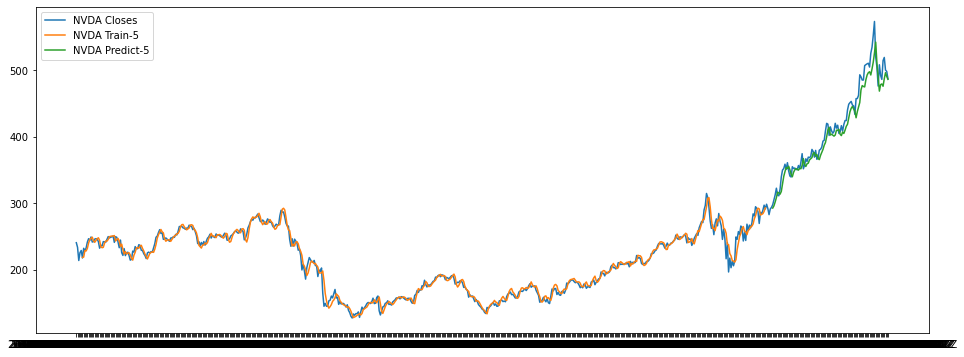

In [35]:
plt.figure(figsize=(16,6))
plt.plot(data.Close, label = ticker+' Closes')
plt.plot(train_predict_plot, label = ticker+' Train-'+str(timestep))
plt.plot(test_predict_plot, label = ticker+' Predict-'+str(timestep))
plt.legend()
plt.show()

In [36]:
print('Number of data[Close] rows = ', len(data['Close']))
print('Length of Train data = ', len(train_predictions))
print('Length of test data = ', len(test_predictions))

Number of data[Close] rows =  663
Length of Train data =  558
Length of test data =  95


In [37]:
data['AITrain'] = train_predict_plot
data['AITest'] = test_predict_plot
data

,Close,US10Y,Close-RSI21,AITrain,AITest
2018-02-01T00:00:00.000Z,240.50,2.78,71.617446,NaN,NaN
2018-02-02T00:00:00.000Z,233.52,2.84,62.205161,NaN,NaN
2018-02-05T00:00:00.000Z,213.70,2.77,44.692608,NaN,NaN
2018-02-06T00:00:00.000Z,225.58,2.79,53.017217,NaN,NaN
2018-02-07T00:00:00.000Z,228.80,2.84,54.947105,NaN,NaN
...,...,...,...,...,...
2020-09-14T00:00:00.000Z,514.89,0.68,57.550703,NaN,476.242077
2020-09-15T00:00:00.000Z,519.64,0.68,58.274657,NaN,487.697122
2020-09-16T00:00:00.000Z,500.58,0.69,54.368021,NaN,496.672445
2020-09-17T00:00:00.000Z,498.54,0.69,53.961481,NaN,491.023336


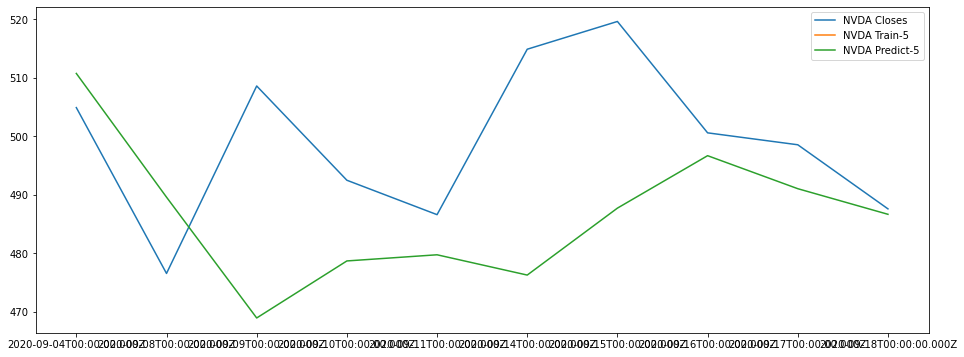

In [38]:
plt.figure(figsize=(16,6))
plt.plot(data.Close[-timestep-5:], label = ticker+' Closes')
plt.plot(train_predict_plot[-timestep-5:], label = ticker+' Train-'+str(timestep))
plt.plot(test_predict_plot[-timestep-5:], label = ticker+' Predict-'+str(timestep))
plt.legend()
plt.show()

In [39]:
data['Abs%Err']=nan
data['DirErr']=nan

In [40]:
#-----STOCK PRICE PREDICTION METRIC-----
for i in range(len(train_predictions)+timestep+timestep,len(scaled_data)):
    data['Abs%Err'][i]=100*(data['AITest'][i]-data['Close'][i])/data['Close'][i]

#-----DIRECTION PREDICTION METRIC-----
for i in range(len(train_predictions)+timestep+timestep+1,len(scaled_data)):
    parity=0
    if ((data['Close'][i] - data['Close'][i-1])*(data['AITest'][i] - data['AITest'][i-1])) > 0:
        data['DirErr'][i]=0
        parity=1
    if parity==0:
        data['DirErr'][i]=1

if DBGmode==1:
    print('Train length = ', len(train_predictions)+timestep)
    print('Total length = ', len(scaled_data))
    ch=len(train_predictions)+timestep+timestep+1
    print('data[Close][i]   = ', data['Close'][ch])
    print('data[Close][i-1] = ', data['Close'][ch-1])
    print('data[AITest][i]= ', data['AITest'][ch])
    print('data[AITest][i-1]= ', data['AITest'][ch-1])
    print('data[DirErr][i]  = ', data['DirErr'][ch])

In [41]:
if DBGmode==1:
    print(data['DirErr'][len(train_predictions)+timestep+timestep+1:len(scaled_data)])
    print(data['Abs%Err'][len(train_predictions)+timestep+timestep:len(scaled_data)])

In [42]:
Tot_test_error = sum(data['DirErr'][len(train_predictions)+timestep+timestep+1:len(scaled_data)])
Tot_test_len = sum(data['DirErr'].notnull())
Test_DirAcc = 100*(Tot_test_len - Tot_test_error) / Tot_test_len
print('timestep=', timestep)
print('')
print('----DIRECTION-----')
print('Total Test Errors = ', Tot_test_error)
print('Total Test Elements = ', Tot_test_len)
print('Test Direction Predict Accuracy = ', Test_DirAcc)
print('')
print('----STOCK PRICE PREDICTION-----')
len(train_predictions)+timestep,len(scaled_data)-timestep
print('Max % Price Error = ', max(data['Abs%Err'][len(train_predictions)+timestep+timestep:len(scaled_data)]))
print('Min % Price Error = ', min(data['Abs%Err'][len(train_predictions)+timestep+timestep:len(scaled_data)]))
print('Average % Price Error = ', statistics.mean(data['Abs%Err'][len(train_predictions)+timestep+timestep:len(scaled_data)]))

timestep= 5

----DIRECTION-----
Total Test Errors =  48.0
Total Test Elements =  94
Test Direction Predict Accuracy =  48.93617021276596

----STOCK PRICE PREDICTION-----
Max % Price Error =  4.357409654768813
Min % Price Error =  -8.465098993138753
Average % Price Error =  -2.1834691751139412


In [43]:
if WritetoFile == 1:
    data.to_csv(ticker+'_predict.csv')
    print('Wrote to file')

In [44]:
if DBGmode == 0:
    pd.set_option('display.max_rows', data.shape[0]+1)
    data

print('timestep=', timestep)
data.tail(timestep+10)

timestep= 5


,Close,US10Y,Close-RSI21,AITrain,AITest,Abs%Err,DirErr
2020-08-28T00:00:00.000Z,525.91,0.74,74.361099,NaN,493.218247,-6.216226,1.0
2020-08-31T00:00:00.000Z,534.98,0.72,75.739196,NaN,502.331834,-6.102689,0.0
2020-09-01T00:00:00.000Z,552.84,0.68,78.165711,NaN,512.590652,-7.280470,0.0
2020-09-02T00:00:00.000Z,573.86,0.66,80.567559,NaN,526.437085,-8.263847,0.0
2020-09-03T00:00:00.000Z,520.62,0.63,62.332222,NaN,542.719193,4.244784,1.0
2020-09-04T00:00:00.000Z,504.90,0.72,58.245107,NaN,510.746380,1.157928,0.0
2020-09-08T00:00:00.000Z,476.52,0.69,51.805898,NaN,489.575880,2.739839,0.0
2020-09-09T00:00:00.000Z,508.60,0.71,57.396171,NaN,468.900061,-7.805729,1.0
2020-09-10T00:00:00.000Z,492.47,0.68,54.084111,NaN,478.659137,-2.804407,1.0
2020-09-11T00:00:00.000Z,486.58,0.67,52.913397,NaN,479.713559,-1.411164,1.0


In [45]:
#Predict for next day from here
st_date_ob = '2018-1-1'
en_date_ob = datetime.date(datetime.now())
#yday = today - timedelta(days=1)
response_ob = get_stock_data(ticker, st_date_ob, en_date_ob)
dates_ob, closes_ob, opens_ob, highs_ob, lows_ob, vols_ob = parse_data(response_ob)

#**** Define New Column Label here
datastock_ob = pd.DataFrame(columns = ['Close'], index = dates_ob)
dfindex_ob = datastock_ob.index
dfindex_ob.name = 'Date'

#**** ADD New Column Data here
datastock_ob['Close']=closes_ob

if ADDUS10Y==1:
    us10y_data_ob = quandl.get("FRED/DGS10", start_date=st_date_ob, end_date=en_date_ob, api_key = 'tNjFxT5wYAG7nbemafxi')
    us10y_data_ob=us10y_data_ob.reset_index()
    us10y_data_ob.rename(columns = {'Value':'US10Y'}, inplace = True) 
    
    for row in range(0,len(us10y_data_ob)):
        us10y_data_ob['Date'][row]=str(us10y_data_ob['Date'][row])[:10]+'T00:00:00.000Z'
    us10y_data_ob=us10y_data_ob.set_index('Date')
    
    #****APPEND US10Y data here to a separate column in a new dataframe
    data_ob=pd.concat([datastock_ob, us10y_data_ob], axis=1, sort=False)

    #fill US10Y NaN with previous value
    data_ob['US10Y'].fillna(method='ffill', inplace=True)
else:
    data_ob=datastock_ob
    
#Add XMA here

if ADDXMA == 1:
    #Enter SMA Data - defined at the top
    #xmasmall=5
    #xmalong=9
    #data['Close-XMA5'] = data.iloc[:,0].rolling(window=smasmall).mean()
    #data['Close-XMA9'] = data.iloc[:,0].rolling(window=smalong).mean()

    #Enter EMA Data - defined at the top
    #xmasmall=7
    #xmalong=14
    data_ob['Close-XMA'+str(xmasmall)] = data_ob.iloc[:,0].ewm(span=xmasmall, adjust=False).mean()
    data_ob['Close-XMA'+str(xmalong)] = data_ob.iloc[:,0].ewm(span=xmalong, adjust=False).mean()

    droprow_ob=xmalong
    data_ob.drop(data_ob.index[0:droprow_ob], inplace = True)

if ADDRSI == 1:
    data_ob['Close-RSI'+str(RSIwindow)] = computeRSI(data_ob['Close'], RSIwindow)
    data_ob.drop(data_ob.index[0:RSIwindow], inplace = True)

data_noofcols_ob = len(data_ob.columns)

datafilt_ob = data_ob[-timestep:].values
print('datafilt_ob')
print(datafilt_ob)

scaled_datafilt_ob = scaler.transform(datafilt_ob)
print('scaled_datafilt_ob')
print(scaled_datafilt_ob)

data_x_ob = []
data_x_ob.append(scaled_datafilt_ob)
data_x_ob = np.array(data_x_ob)
print(data_x_ob.shape)
print('data_x_ob')
print(data_x_ob)
#test_x = np.reshape(test_x, (test_x.shape[0], test_x.shape[2], 1))

train_predictions_ob = model.predict(data_x_ob)
print('train_predictions_ob')
print(train_predictions_ob)

# create empty table with data_noofcols fields
train_predictions_like_ob = np.zeros(shape=(len(train_predictions_ob), data_noofcols_ob))
# put the predicted values in the right field
train_predictions_like_ob[:,0] = train_predictions_ob[:,0]
# inverse transform and then select the right field
train_predictions_ob = scaler.inverse_transform(train_predictions_like_ob)[:,0]

print('inverse scaled train_predictions_ob')
print(train_predictions_ob)

datafilt_ob
[[514.89         0.68        57.5507026 ]
 [519.64         0.68        58.27465724]
 [500.58         0.69        54.36802116]
 [498.54         0.69        53.9614808 ]
 [487.57         0.69        51.77548141]]
scaled_datafilt_ob
[[0.8680111  0.05882353 0.57799928]
 [0.87864273 0.05882353 0.59127257]
 [0.83598192 0.0625     0.51964667]
 [0.83141591 0.0625     0.51219298]
 [0.80686244 0.0625     0.47211395]]
(1, 5, 3)
data_x_ob
[[[0.8680111  0.05882353 0.57799928]
  [0.87864273 0.05882353 0.59127257]
  [0.83598192 0.0625     0.51964667]
  [0.83141591 0.0625     0.51219298]
  [0.80686244 0.0625     0.47211395]]]
train_predictions_ob
[[0.787703]]
inverse scaled train_predictions_ob
[479.00993636]


<ipython-input-45-3021b0485a82>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  us10y_data_ob['Date'][row]=str(us10y_data_ob['Date'][row])[:10]+'T00:00:00.000Z'
/Users/prasannaob/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [46]:
train_predictions_ob

array([479.00993636])